# item 1 - Get data

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

%matplotlib inline

import numpy as np
import os, sys
import imageio
import pandas as pd
import matplotlib.pyplot as plt

path_txt = os.path.join('dataset', 'train', 'gt')
path_mask = os.path.join('dataset', 'train', 'mask')

dirs_txt = os.listdir(path_txt)
dirs_mask = os.listdir(path_mask)

data = dict()

for gt in dirs_txt:
    with open(os.path.join(path_txt, gt)) as f:
        lines = f.readlines()
        
        im_name = gt.replace('gt', 'mask').replace('txt', 'png')
        im_open = (imageio.imread(os.path.join(path_mask, im_name)))

        lista = list()
        for l in lines:
            tly, tlx, bry, brx, tipo = l.split(' ')  
            tly, tlx, bry, brx = map(float, [tly, tlx, bry, brx])
            d = dict()
            d['type'] = tipo.strip()
            
            w = brx - tlx
            h = bry - tly
            
            d['width'] = w
            d['height'] = h
            d['bbox_area'] = w*h
            d['form_factor'] = w/h
            
            d['tly'] = round(tly)
            d['tlx'] = round(tlx)
            d['bry'] = round(bry)
            d['brx'] = round(brx)
            
            sub_mask = im_open[d['tly']:d['bry'], d['tlx']:d['brx']]
            mask_area = np.count_nonzero(sub_mask)
            d['mask_area'] = mask_area
            d['filling_ratio'] = mask_area / d['bbox_area']
            
            lista.append(d)
            
        data[gt] = lista
    

                   type   width  height  form_factor   bbox_area  mask_area  \
gt.01.001555.txt 0    A   79.70   72.51     1.099159   5779.0470       2905   
gt.01.001777.txt 0    A   86.73   79.25     1.094385   6873.3525       3438   
gt.01.001784.txt 0    A  140.81  125.71     1.120118  17701.2251       8927   
gt.01.001785.txt 0    A  184.71  165.30     1.117423  30532.5630      15232   
gt.01.001787.txt 0    A  104.12  103.53     1.005699  10779.5436       5419   
gt.01.001788.txt 0    A   87.64   85.89     1.020375   7527.3996       3752   
gt.01.001789.txt 0    A  130.59  131.18     0.995502  17130.7962       8612   
gt.01.001796.txt 0    A   80.73   77.05     1.047761   6220.2465       3134   
gt.01.001797.txt 0    A   68.55   64.30     1.066096   4407.7650       2186   
gt.01.001798.txt 0    A   62.20   58.10     1.070568   3613.8200       1804   
gt.01.001466.txt 0    A  152.59  156.60     0.974393  23895.5940      11992   
gt.01.001776.txt 0    A  127.12  117.21     1.084549

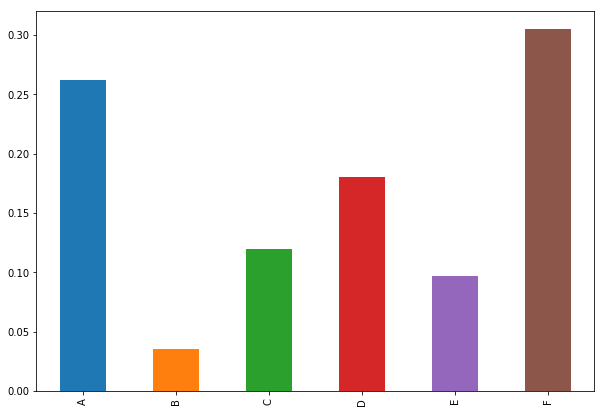

In [3]:
# Write table
columns = ['type','width','height','form_factor','bbox_area','mask_area','filling_ratio']
df = pd.DataFrame.from_dict({(i,n): data[i][n]
                        for i in data.keys()
                        for n,v in enumerate(data[i])}, columns=columns, orient='index').sort_values(['type'])
print(df)
#df['form_factor'].plot(figsize=(10, 7))

# Count signals
print(df['type'].value_counts(sort=False).reindex(['A','B','C','D','E','F']))
df['type'].value_counts(sort=False,normalize=True).reindex(['A','B','C','D','E','F']).plot(figsize=(10, 7),kind='bar',sort_columns=True)




In [12]:
type_counts = df.groupby('type').aggregate(np.std)
type_counts

#type_counts = df.groupby('type').aggregate(np.median)
#type_counts = df.groupby('type').aggregate(np.average)
#type_counts = df.groupby('type').aggregate(np.std)


,width,height,form_factor,bbox_area,mask_area,filling_ratio
type,,,,,,
A,41.335729,38.008033,0.072605,8279.862551,4143.273109,0.004836
B,23.770842,30.345938,0.147600,4742.369013,2355.826008,0.002785
C,46.247714,43.710066,0.108059,11043.923810,8649.408203,0.002155
D,34.465644,32.730861,0.084535,6220.392965,5094.719034,0.054970
E,38.362295,42.532158,0.103603,9622.292967,7538.824465,0.002154
F,40.540153,39.199496,0.178012,9245.579115,9209.599015,0.007709


In [51]:
# Group data by "type" (letter) and get statistics:

# Function = get_stats (only shape, aspect ratio, etc, NOT COLOUR)

# Queremos estadisticas de tamaño y forma en función de cada letra        

In [ ]:
# Plot and compare results

MOSTRAR IMÁGENES REPRESENTATIVAS DE CADA MUESTRA QUE MUESTREN LOS COLORES TIPICOS QUE ESPERAMOS ENCONTRAR - 
ARGUMENTAR POR QUE ESPERAMOS VER 4

# Item 2 - Split training dataset

Al separar por tipo, tenemos que armar un algoritmo que nos separe el set de training en dos carpetas, 
separando mismos tipos en 70% / 30%.

# Item 3 - Separation by colour


Para cada imagen de prueba, nos basamos en el diccionario y usamos el bounding box que ya calculamos.

Recortamos la imagen, le calculamos el histograma. Sumamos los histogramas de todas las imágenes y obtenemos la suma total.

Luego hacemos lo mismo y al recortar la roi de cada imagen convertimos la roi de rgb a hsv, calculamos el histograma
y obtenemos la suma de todos los histogramas. 

Con estas cosas deberíamos poder obtener los thresholds a aplicar luego.


Hacer gráficos chetos de los histogramas. Ajustar con multiples gaussianas, calcular promedio, mediana, std, etc.
Compararlos y elegir el mejor.

Luego aplicar las máscaras con los thresholds calculados

In [92]:
# Convert RGB images tu HUE images

# Get stats from HUE images

# Plot and compare

# Select thresholds (RGB y HUE)

# Create masks using previous thresholds



# Calculate histograms:

In [17]:
from skimage import color

path_jpg = os.path.join('dataset', 'train', 'jpg')
dirs_jpg = os.listdir(path_jpg)

def color_histogram(gt_dictionary, path_jpg, color_space):

    c0_hist = np.zeros(255)
    c1_hist = np.zeros(255)
    c2_hist = np.zeros(255)

    for gt, values in list(gt_dictionary.items()):
        for v in values:

            jpg_name = gt.replace('gt.', '').replace('txt', 'jpg')
            mask_name = gt.replace('gt', 'mask').replace('txt', 'png')
            
            jpg_roi = imageio.imread(os.path.join(path_jpg, jpg_name))[v['tly']:v['bry'], v['tlx']:v['brx']]
            mask_roi = imageio.imread(os.path.join(path_mask, mask_name))[v['tly']:v['bry'], v['tlx']:v['brx']]

            if color_space=='rgb':
                final_roi = jpg_roi
                r0 = 0
                rf = 255
                
            elif color_space=='hsv':
                final_roi = color.rgb2hsv(jpg_roi) 
                r0 = 0
                rf = 1
                
            elif color_space=='ycbcr':
                final_roi = color.rgb2ycbcr(jpg_roi)
                r0 = 0
                rf = 255
                
            elif color_space=='xyz':
                final_roi = color.rgb2xyz(jpg_roi)
                r0 = 0
                rf = 1
                
            mask_roi[mask_roi==0] = 0
            mask_roi[mask_roi!=0] = 1
            
            bins = np.histogram(final_roi[:,:,0] * mask_roi, bins=255, range=(r0,rf))[1]
            c0_hist += np.histogram(final_roi[:,:,0] * mask_roi, bins=255, range=(r0,rf))[0]
            c1_hist += np.histogram(final_roi[:,:,1] * mask_roi, bins=255, range=(r0,rf))[0]
            c2_hist += np.histogram(final_roi[:,:,2] * mask_roi, bins=255, range=(r0,rf))[0]
    
    return bins, c0_hist, c1_hist, c2_hist, r0, rf


################################################
# Calculate histograms with traffic signal data:
################################################

# RGB histograms:

bins, r_hist, g_hist, b_hist, rgb0, rgbf = color_histogram(data, path_jpg, 'rgb')

# HSV histograms:

hbins, h_hist, s_hist, v_hist, hsv0, hsvf = color_histogram(data, path_jpg, 'hsv')

# yCbCr histograms:

ybins, y_hist, cb_hist, cr_hist, ycbcr0, ycbcrf = color_histogram(data, path_jpg, 'ycbcr')

# X,Y,Z histograms:

xbins, xx_hist, yy_hist, zz_hist, xyz0, xyzf = color_histogram(data, path_jpg, 'xyz')


/home/agus/miniconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:269: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/home/agus/miniconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/home/agus/miniconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/home/agus/miniconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:283: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


# Plot histograms:

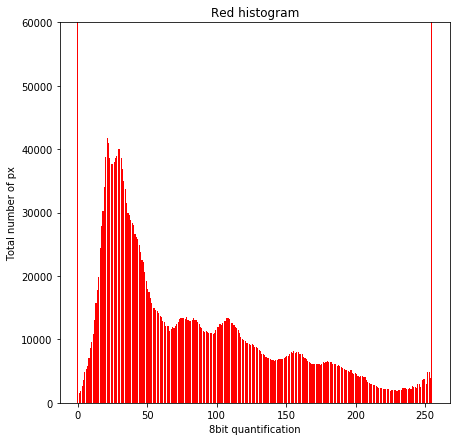

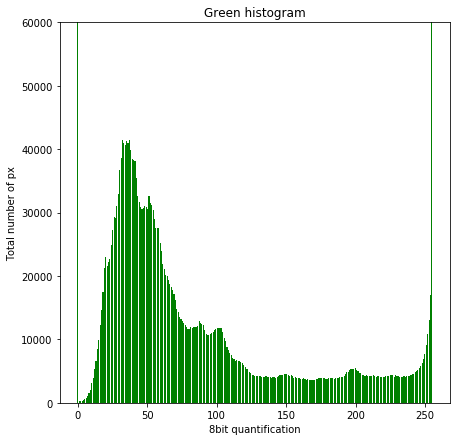

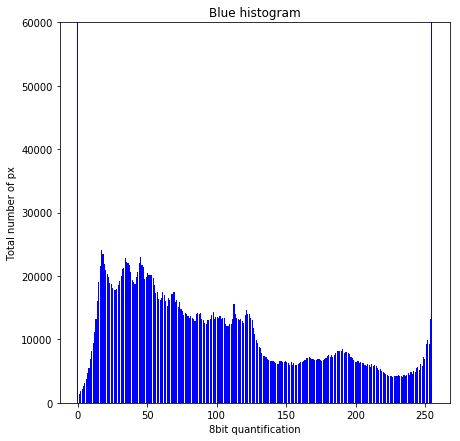

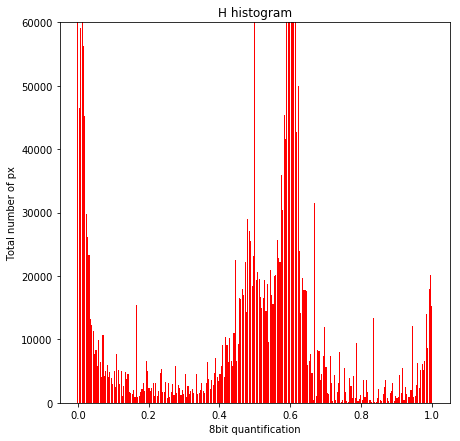

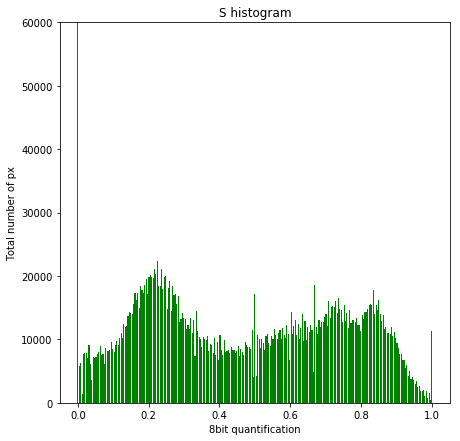

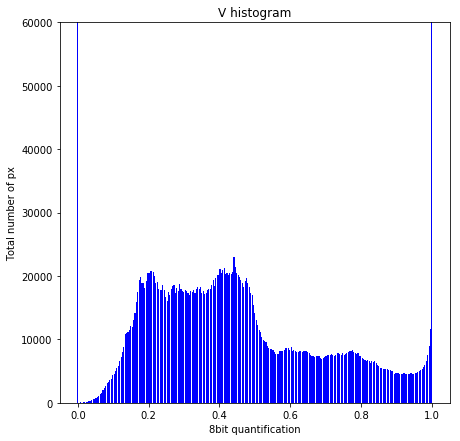

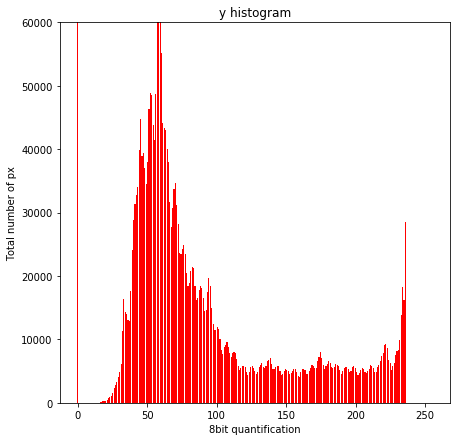

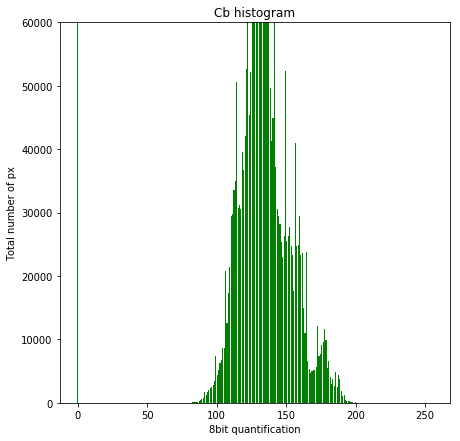

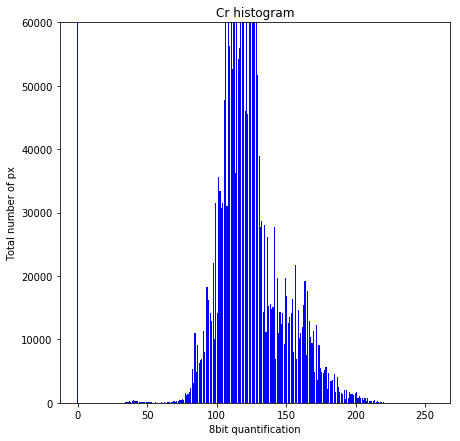

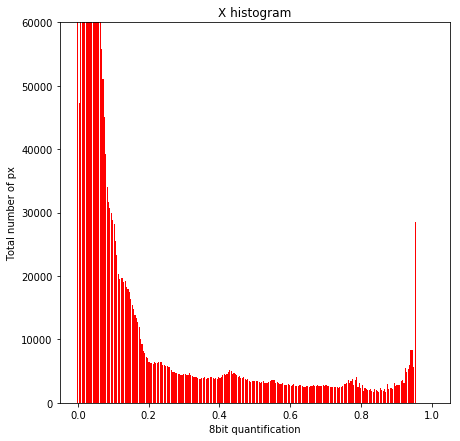

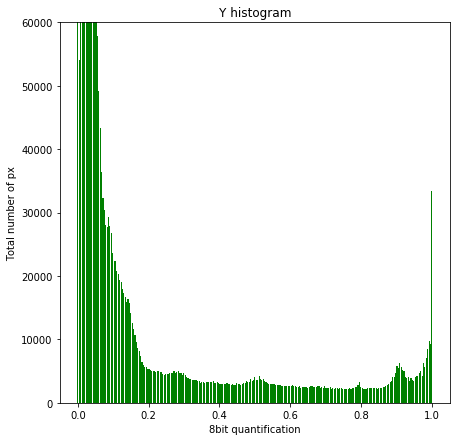

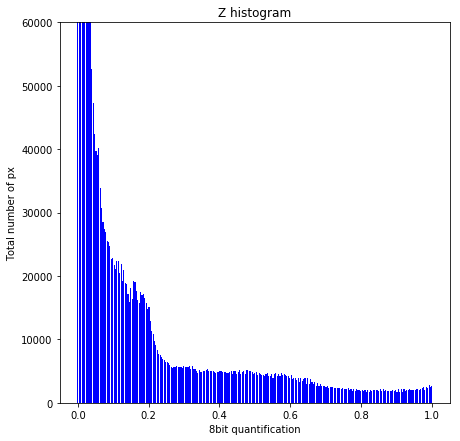

In [19]:
# Questions: why can't I use the variable 'bins' to plot the histograms?
# Why do I get a divergence at 255?
# Why am I dividing by zero when converting to HSV?

def plot_histogram(hist, r0, rf, color_name, color_plot):

    x = np.linspace(r0, rf, 255)
    
    plt.figure(figsize=(7,7))
    plt.bar(x, hist, color=color_plot, width=0.8*(rf-r0)/255)
    plt.ylim((0,60000))
    plt.title(color_name + ' histogram')
    plt.xlabel('8bit quantification')
    plt.ylabel('Total number of px')
    plt.show()
    
# Plot RGB histograms:

plot_histogram(r_hist, rgb0, rgbf, 'Red', 'r')
plot_histogram(g_hist, rgb0, rgbf, 'Green', 'g')
plot_histogram(b_hist, rgb0, rgbf, 'Blue', 'b')

# Plot HSV histograms:

plot_histogram(h_hist, hsv0, hsvf, 'H', 'r')
plot_histogram(s_hist, hsv0, hsvf, 'S', 'g')
plot_histogram(v_hist, hsv0, hsvf, 'V', 'b')

# Plot yCbCr histograms:

plot_histogram(y_hist, ycbcr0, ycbcrf, 'y', 'r')
plot_histogram(cb_hist, ycbcr0, ycbcrf, 'Cb', 'g')
plot_histogram(cr_hist, ycbcr0, ycbcrf, 'Cr', 'b')

# Plot xyz histograms:

plot_histogram(xx_hist, xyz0, xyzf, 'X', 'r')
plot_histogram(yy_hist, xyz0, xyzf, 'Y', 'g')
plot_histogram(zz_hist, xyz0, xyzf, 'Z', 'b')


# Item 4 - Evaluate colour masks 

Comparar las máscaras obtenidas con el ground truth.

Podemos ver si sirven las funciones que ya nos dieron hechas.

# Lo que sigue a partir de aqui fueron pruebas hechas el martes:

In [ ]:
print(data['gt.00.005025.txt'][0])
print(data['gt.00.005025.txt'][1])

for gt in dirs_txt:
    print(data[gt][0]['filling_ratio'])

In [ ]:
for mask in dirs_mask:
    gt = mask.replace('mask', 'gt').replace('png', 'txt')
    m = (imageio.imread(os.path.join(path_mask, mask)))
    mask_area = m.sum()
    d = data[gt]
    d['mask_area'] = mask_area
    d['filling_ratio'] = mask_area / d['bbox_area']
    
    print(d['mask_area'], d['filling_ratio'], mask)
    

In [ ]:
print(dirs_mask[0].replace('mask', 'gt').replace('png', 'txt'))
print(dirs_txt[0])


In [ ]:
import matplotlib.pyplot as plt

% matplotlib inline

m = imageio.imread(os.path.join(path_mask,'mask.00.005025.png')).astype(np.int8)

plt.imshow(m[146:201, 1324:1375])
